In [1]:
import numpy  as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
from scipy.stats import pearsonr

In [2]:
f = xr.open_dataset('~/work/LCC_pred/data/ERA5_SSF_monthly.nc')

lat      = f['lat']
lon      = f['lon']
time     = f['time']
lsm      = f['lsm']
LCF      = (f['cldarea_low_day_mon'] + f['cldarea_low_daynight_mon'])/2.0/100.0 # unit, 1

LCF_mean = LCF.where(lsm<=0.1).mean(axis=0)
LCF_mean_cyc, lon_cyc = add_cyclic_point(LCF_mean, coord=lon)

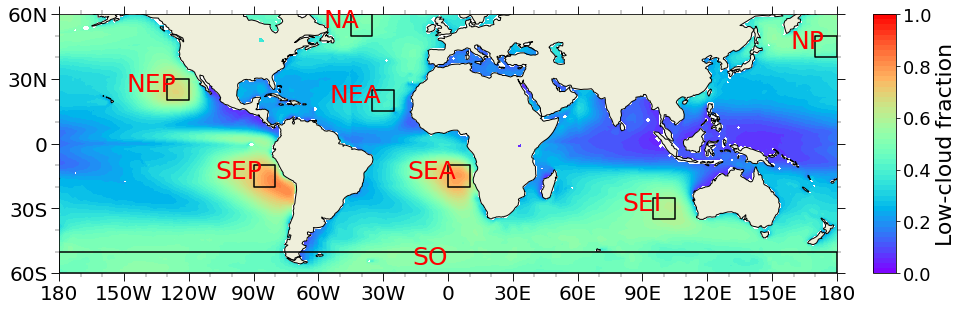

In [3]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import cm
import cartopy.feature as cfeature
import geocat.viz.util as gvutil
from shapely.geometry.polygon import LinearRing

fig = plt.figure(figsize=(15, 15))

projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
axgr = AxesGrid(fig,
                111,
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.7,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.5,
                cbar_size='3%',
                label_mode=''
                )  # note the empty label_mode

def get_box(lon, lat):
    lons = [lon[0], lon[1], lon[1], lon[0]]
    lats = [lat[0], lat[0], lat[1], lat[1]]
    ring = LinearRing(list(zip(lons, lats)))
    return(ring)

ring1 = get_box([-90,-80], [-20, -10]) # Peruvian
ring2 = get_box([0, 10], [-20, -10])   # Namibian
ring3 = get_box([-130,-120], [20, 30]) # Californian
ring4 = get_box([95,105], [-35,-25])   # Australian
ring5 = get_box([-35, -25], [15, 25])  # Canarian

ring6 = get_box([170,180], [40,50])  # North Pacific
ring7 = get_box([-45,-35], [50,60])    # North Atlantic
ring8 = get_box([-180,180], [-60,-50]) # Circumpolar Ocean

ring  = [ring1, ring2, ring3, ring4, ring5, ring6, ring7, ring8]
texts = ['SEP', 'SEA', 'NEP', 'SEI', 'NEA', 'NP', 'NA', 'SO']

clev = np.arange(0, 1.02, 0.02)

for i, ax in enumerate(axgr):

    p = ax.contourf(lon_cyc, lat, LCF_mean_cyc, clev, 
                    vmin=0, vmax=1.0,
                    cmap=plt.cm.rainbow, transform=projection)

    ax.coastlines()
    ax.add_feature(cfeature.LAND)

    gvutil.add_major_minor_ticks(ax, labelsize=20)

    gvutil.set_axes_limits_and_ticks(ax,
                                     xticks=np.linspace(-180, 180, 13),
                                     yticks=np.linspace(-60, 60, 5))

    gvutil.add_lat_lon_ticklabels(ax, zero_direction_label=False)
    
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
    
    # plot boxes
    for i, ir in enumerate(ring):
        ax.add_geometries([ir], crs=projection, facecolor='none', edgecolor='black', lw=1.5)
        x0 = 0 if i==7 else np.mean(ir.xy[0])
        ax.annotate(texts[i], xy=(x0, np.mean(ir.xy[1])), fontsize=25, c='red', ha = 'right')

cax = axgr.cbar_axes[0]
cbar = cax.colorbar(p)
ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)

axis = cax.axis[cax.orientation]
axis.label.set_text(r'Low-cloud fraction')
axis.label.set_size(22)
axis.major_ticklabels.set_size(18)



In [4]:
ff = pd.read_pickle("/glade/work/hpzhang/LCC_pred/data/data_monthly.pkl").dropna()

df  = ff.drop(columns=['lat', 'lon', 'lsm', 'T1000', 'T700'])
df = df[df.index.year.isin(np.arange(2003,2019))]

#corr = df.corr()

In [5]:
r    = df.corr(method=lambda x, y: pearsonr(x, y)[0]) 
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) #- np.eye(*rho.shape)

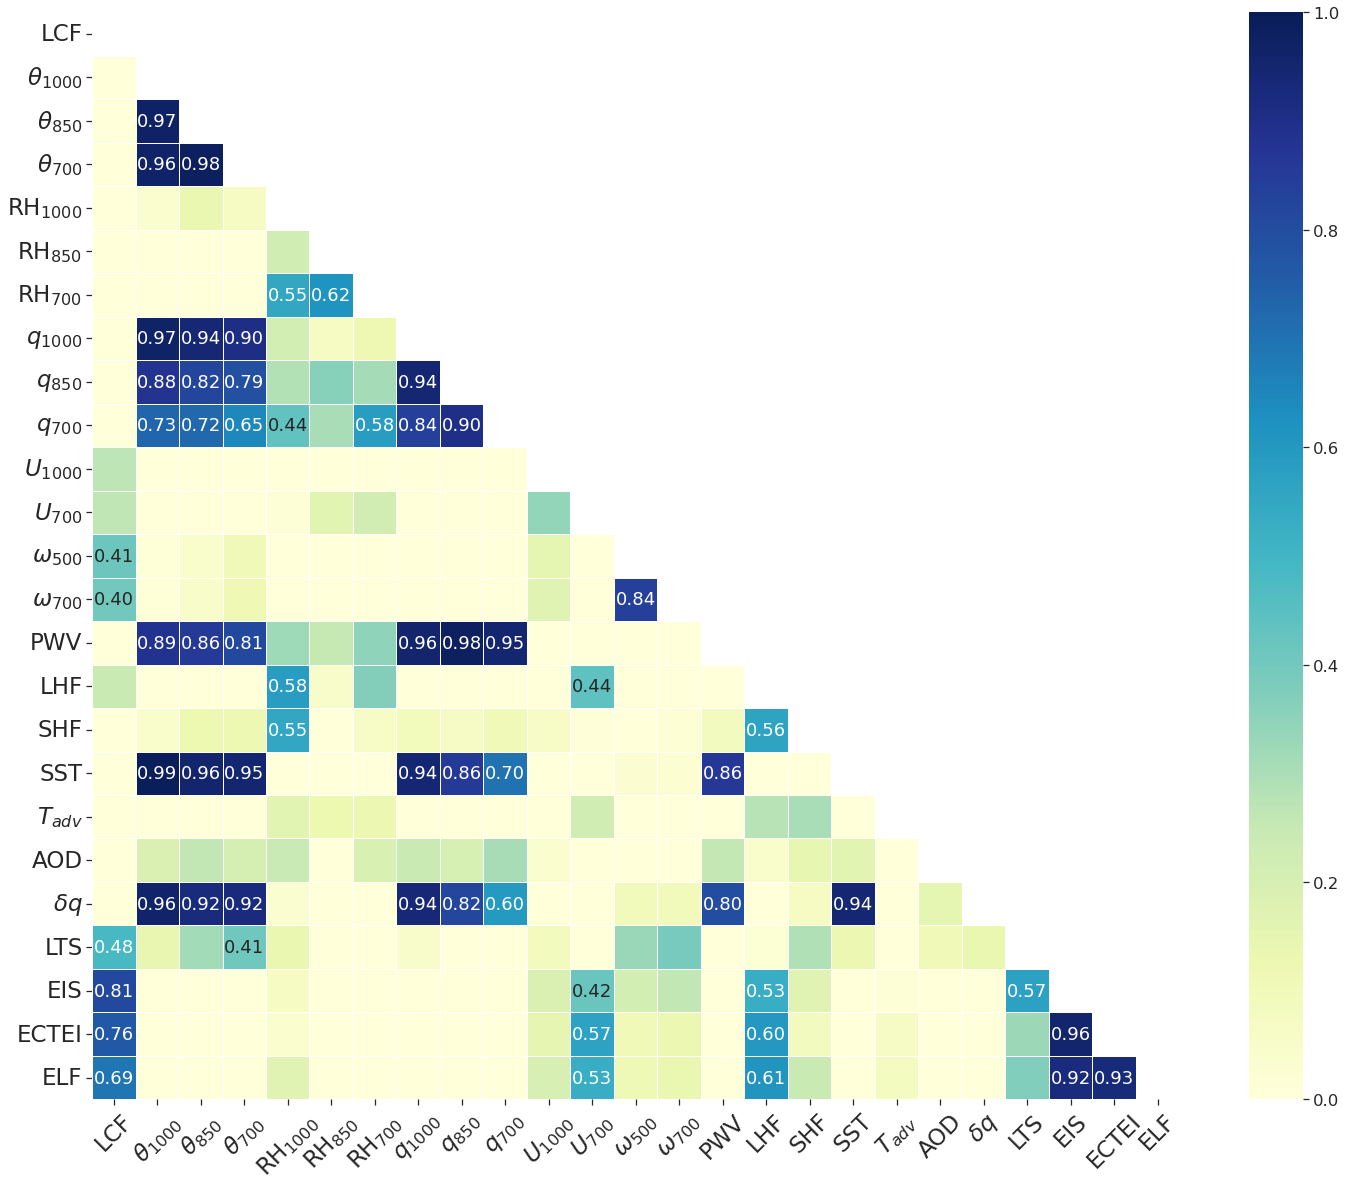

In [6]:

r = r.mask(pval>=0.05)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 1.5)

mask = np.zeros_like(r)
mask[np.triu_indices_from(mask)] = True

def my_mask(x):
    if x >= 0.4:
        y = '{0:.2f}'.format(x)
    else:
        y = ''
    return(y)

f, ax = plt.subplots(figsize=(25, 20))
g1 = sns.heatmap(r, ax=ax,
                 vmin=0, vmax=1,
                 annot=r.applymap(my_mask), fmt='',
                 square=True,
                 mask=mask,
                 cmap="YlGnBu",
                 linewidths=.5)

labels = ['LCF', 
          r'$\theta_{1000}$', r'$\theta_{850}$', r'$\theta_{700}$', 
          r'RH$_{1000}$', r'RH$_{850}$', r'RH$_{700}$', 
          r'$q_{1000}$', r'$q_{850}$', r'$q_{700}$', 
          r'$U_{1000}$', r'$U_{700}$',
          r'$\omega_{500}$', r'$\omega_{700}$',
          'PWV',
          'LHF', 'SHF', 'SST',
          r'$T_{adv}$',
          'AOD',
          r'$\delta$$q$', 
          'LTS', 'EIS', 'ECTEI', 'ELF',
         ]

g1.tick_params(axis='x', rotation=45)
g1.set_xticklabels(labels, fontsize = 23)
g1.set_yticklabels(labels, fontsize = 23)
plt.show()





In [7]:
df.columns

Index(['LCF', 'TH1000', 'TH850', 'TH700', 'RH1000', 'RH850', 'RH700', 'Q1000',
       'Q850', 'Q700', 'U1000', 'U700', 'OMEGA500', 'OMEGA700', 'PWV', 'LH',
       'SH', 'SST', 'Tadv', 'AOD', 'dQ', 'LTS', 'EIS', 'ECTEI', 'ELF'],
      dtype='object')

In [8]:

### plot NN loss

loss = np.load('/glade/work/hpzhang/LCC_pred/data/NN/loss.npy')
val_loss  = np.load('/glade/work/hpzhang/LCC_pred/data/NN/val_loss.npy')

mae = np.load('/glade/work/hpzhang/LCC_pred/data/NN/mae.npy')
val_mae = np.load('/glade/work/hpzhang/LCC_pred/data/NN/val_mae.npy')

epochs = range(1, len(loss) + 1)


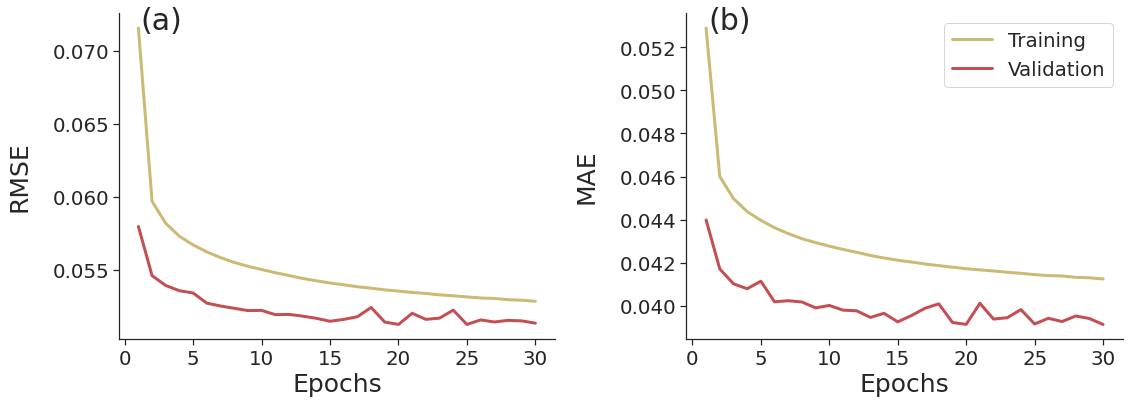

In [9]:

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 1.8)

fig = plt.figure(figsize=[18, 6])
gd  = (1, 2)
ax1 = plt.subplot2grid(gd, (0, 0))
ax2 = plt.subplot2grid(gd, (0, 1))

### plot1 ###
ax1.plot(epochs, loss**0.5, 'y', label='Training', linewidth=3)
ax1.plot(epochs, val_loss**0.5, 'r', label='Validation', linewidth=3)
ax1.set_xlabel('Epochs', fontsize=25)
ax1.set_ylabel('RMSE', fontsize=25)

### plot2 ###
ax2.plot(epochs, mae, 'y', label='Training', linewidth=3)
ax2.plot(epochs, val_mae, 'r', label='Validation', linewidth=3)
ax2.set_xlabel('Epochs', fontsize=25)
ax2.set_ylabel('MAE', fontsize=25)
ax2.legend()

ax1.annotate('(a)', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=30)
ax2.annotate('(b)', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=30)

ax1.get_yaxis().set_label_coords(-0.2, 0.5)
ax2.get_yaxis().set_label_coords(-0.2, 0.5)

plt.subplots_adjust(wspace=0.3)
plt.show()

